In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!mkdir  /content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13

mkdir: cannot create directory ‘/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13’: File exists


In [ ]:
!cp -R /content/MyDrive/MyDrive/Twitter_dataset_final/Final_Dataset_v1 /content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13

#Installing necessary packages:

In [ ]:
!pip install tweepy
!pip install googletrans
!pip install deep_translator # To translate from one language to another
!pip install flair # To find sentiment of the tweets
!pip install langdetect

     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 1.3 MB 9.2 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=fdb1674d8dff4c37a825b2198317abd38756b6ecb3c3d9ec141c3fc25bc6abbf
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans
     |████████████████████████████████| 128 kB 7.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 401 kB 3.8 MB/s 
     |████████████████████████████████| 19.7 MB 12.3 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |██

In [ ]:
import os
import csv
import pickle
import re
import tweepy 
import datetime
import numpy as np
import pandas as pd
import collections
from langdetect import detect
from flair.data import Sentence
from flair.models import TextClassifier
from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
!unzip '/content/Twitter_Dataset.zip'

In [ ]:
!zip -r /content/datav12.zip /content/Twitter_Dataset 

#Retrieving user Tweets and replies:

In [ ]:
# These keys can be generated by making developer account in twitter
consumer_key= "XXXXXXXXXXXXXXXXX"
consumer_secret= "XXXXXXXXXXXXXXXXXXX"
access_token_key= "XXXXXXXXXXXXXXXXXXXXXXX"
access_token_secret= "XXXXXXXXXXXXXXXXXXXXXXXXXX"

#authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

new_tweets = api.user_timeline(screen_name = user_name count=250,tweet_mode='extended')<br>

* make initial request for most recent tweets (200 is the maximum allowed count)
* mostly it covers 1 month tweets
* But another way to fetch more than 200 tweets is using tweepy.cursor
* https://stackoverflow.com/questions/42225364/getting-whole-user-timeline-of-a-twitter-user

* https://stackoverflow.com/questions/46734636/tweepy-api-user-timeline-count-limited-to-200


In [ ]:
# We can give username list as shown below to fetch tweets & replies of user
username_list=["RahulGandhi",'AmitShah','myogiadityanath','smritiirani','ArvindKejriwal','rajnathsingh','nsitharaman','nitin_gadkari','DrRPNishank','MamataOfficial','priyankagandhi']
# in case for every user we can't retrieve all the tweets due to limited access then we can try by giving username one by one
#username_list=["smritiirani"]

In [ ]:
def get_all_tweets(user_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = user_name,count=50,tweet_mode='extended')
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    return alltweets

def create_dataframe_of_tweets(all_tweets,username):
    
  # Creating dataframe from extracted tweets
  outtweets = [[tweet.full_text.encode("utf-8").decode("utf-8"),
              tweet.id_str, 
                tweet.created_at, 
                tweet.favorite_count, 
                tweet.retweet_count, ]
              for idx,tweet in enumerate(all_tweets)]



  df = pd.DataFrame(outtweets,columns=["text","id","created_at","favorite_count","retweet_count"])
  df=df.drop(columns=['favorite_count','retweet_count'])
  temp = df['text'].str.split("http", n=1, expand=True)
  temp = temp[0].astype(str)
  df["text"]=temp
  df.to_csv('/content/drive/MyDrive/Twitter_Dataset/'+username+'/'+username+'_tweets'+'.csv')
  df

In [ ]:
# Retrieving top 50 twitter post of top 10 leaders based on userid 
tweet_ids=[]
for user_name in username_list:
  all_tweets=get_all_tweets(user_name)
  df=create_dataframe_of_tweets(all_tweets,user_name)
  tweet_ids.append([tweet.id_str for idx,tweet in enumerate(all_tweets)])
  

In [ ]:
import pickle
with open('tweet_ids_latest', 'rb') as fileobj:
  tweet_ids = pickle.load(fileobj)

**Fetching replies**

In [ ]:
def replies_from_tweet_id(tweet_ids,username):
  replies=[]
  for tweet in tweepy.Cursor(api.search,q='to:'+username, result_type='recent',timeout=999999,tweet_mode='extended',count=60000).items(60000):
    if hasattr(tweet, 'in_reply_to_status_id_str'):
        if (tweet.in_reply_to_status_id_str in tweet_ids):
            replies.append(tweet)

  for tweet_id in tweet_ids:
    with open('./Data/'+username+'/'+tweet_id+'.csv', 'w') as f:
      csv_writer = csv.DictWriter(f, fieldnames=('id','text','date'))
      csv_writer.writeheader()
      for tweet in replies:
          if tweet.in_reply_to_status_id_str==tweet_id:
            row = {'id':tweet.in_reply_to_status_id_str,'text': tweet.full_text.replace('\n', ' ').strip('@'+username),'date':tweet.created_at }
            csv_writer.writerow(row)

In [ ]:
# Fetching replies based on given tweetid and username
replies_from_tweet_id(tweet_ids[1],'smritiirani')

#**Preprocessing of tweets:**


What will i do as preprocessing part:
* removing mentions @
* removing links
* removing stickers
* removing emojis
* removing punctuation marks and digits
* removing links


In [ ]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def preprocessing(text):

    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub(r'[\d+]', '', text.lower()) # remove numerical values and convert to lower case
    return text

In [ ]:
def pre_process_str(txt):

  try:
    x = GoogleTranslator(source='auto', target='en').translate(txt)
  except:
    x = txt
    pass

  x = re.sub(r'http\S+', '',str(x)) # remove link
  x = re.sub(r'www\S+', '',str(x)) # remove link
  x = re.sub(r"(?:\@|https?\://)\S+", "",x)

  x = remove_emojis(x)
  x = preprocessing(x)
  x = re.sub(' {2,}', ' ',str(x))

  return x


In [ ]:
sid = SentimentIntensityAnalyzer()

def pol_txt(txt):
  # global count
  # global idx
  if(len(txt)==0):
    return 'neu'
  dic = sid.polarity_scores(txt)
  
  val = dic.values()
  val = list(val)[:3] # to ignore 4th val compound
  val = val.index(max(val))
  
  
  if (dic['compound'] < -0.5):
    x = 'neg'
  else:
    x = 'pos'
    
  return x



In [ ]:
def preprocessing_and_sentiment(directory):
# iterate over files in that directory
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        print(f)
        df=pd.read_csv(f)
        if not(df.empty):
          try:
            df['processed_text'] = df.text.apply(pre_process_str)
            df['sentiment'] = df.processed_text.apply(pol_txt)
          except:
            print('except')
            pass
        
          df.to_csv(f,index=False)

In [ ]:
username_list=['AmitShah','ArvindKejriwal','DrRPNishank','MamataOfficial','narendramodi','nitin_gadkari','nsitharaman','priyankagandhi','rajnathsingh','smritiirani']


In [ ]:
for uname in username_list:
  path_of_post='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname
  preprocessing_and_sentiment(path_of_post)

/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/AmitShah/AmitShah_tweets.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/ArvindKejriwal/ArvindKejriwal_tweets.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/DrRPNishank/DrRPNishank_tweets.csv


In [ ]:
uname='smritiirani'
path_of_replies='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname+'/Rep'
preprocessing_and_sentiment(path_of_replies)

/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507610579518705670.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507733796203884547.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507992368456548354.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507962854292353027.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507612696153186310.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507742644029386757.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507619541282537472.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507967178712231940.csv
/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/Rep/1507613

# **Detecting language of the tweet and storing in one column**

In [ ]:
# Adding languages of the tweets:

import os

def language_detector(directory):
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        print(f)
        df=pd.read_csv(f)
        langs=[]
        if not(df.empty):
          for i in range(len(df['processed_text'])):
            try:
              l=detect(df['processed_text'][i])
              if(l=='en' or l=='hi' or l=='gu'):
                langs.append(l)
              else:
                langs.append('other')
            except:
              langs.append('other')
          df['Language']=langs
          df.to_csv(f,index=False)


In [ ]:
uname='smritiirani'
path_of_post='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname
path_of_replies='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname+'/Rep'
language_detector(path_of_post)
language_detector(path_of_replies)

# Entity tagger and wordcloud

In [ ]:
NER = spacy.load("en_core_web_sm")

In [ ]:
all_entities=[]

def find_entities(directory):
  for filename in os.listdir(directory):
      #all_entities=[]
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        df=pd.read_csv(f)
        if not(df.empty):
          ent_lst=[]
          for tweet in df.iloc[:,1]:
            raw_text=tweet
            try:
              text1= NER(raw_text)
            except:
              pass
            entity_lst=[]
            for word in text1.ents:
              entity_lst.append(word.label_)
              all_entities.append(word.label_)
            ent_lst.append(entity_lst)
          df['entities']=ent_lst
          df.to_csv(f,index=False)
  return all_entities

In [ ]:
uname='smritiirani'
all_post=[]
#for uname in username_list:
path_of_post='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname
all_post=find_entities(path_of_post)

In [ ]:
len(all_post)

101

In [ ]:
uname='smritiirani'
path_of_replies='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname+'/Rep'
user_wise_c_entities=find_entities(path_of_replies)

In [ ]:
len(user_wise_c_entities)

1627

In [ ]:
final_list = [*all_post, *user_wise_c_entities]
len(final_list)

1728

In [ ]:
with open('/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/final_list', 'wb') as fileobj:
  pickle.dump(final_list, fileobj)

In [ ]:
with open('/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/smritiirani/final_list', 'rb') as fileobj:
  final_list=pickle.load(fileobj)

* creating wordcloud

In [ ]:
def wordcloud_creator(words_list):
  word_cloud = WordCloud(collocations = False, background_color = 'white',width=3000, height=1500).generate(' '.join(words_list))
  plt.figure( figsize=(20,10) )
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

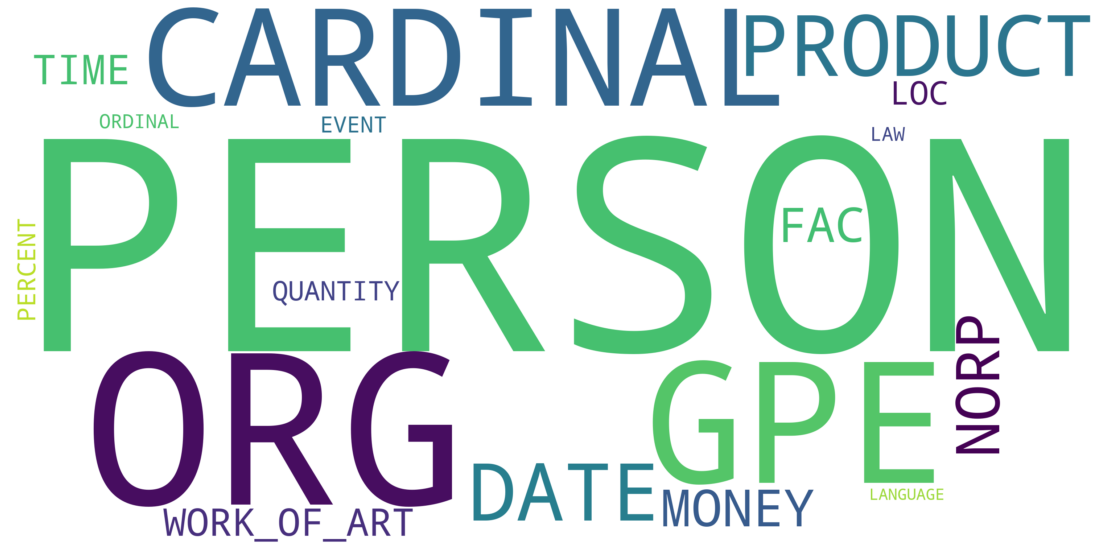

In [ ]:
wordcloud_creator(final_list)

In [ ]:
counted_words = collections.Counter(final_list)
counted_words.most_common()[:5]


[('PERSON', 491),
 ('ORG', 480),
 ('GPE', 288),
 ('CARDINAL', 184),
 ('PRODUCT', 77)]

In [ ]:

#set of stopwords
additional  = ['rt','rts','retweet']
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords=set().union(stopwords,additional)
# wordnet lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
def text_to_tokens(text):

    tokens = nltk.word_tokenize(text) # tokenization
    tokens = [token for token in tokens if token not in stopwords] # removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatization
    
    return ' '.join(tokens)
    return text

In [ ]:
# finding tweets which fulfill all the conditions
word_cloud_string=[]
uname='smritiirani'

directory='/content/MyDrive/MyDrive/Twitter_dataset_final/Data_v13/Final_Dataset_v1/'+uname+'/Rep/'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      df=pd.read_csv(f)
      if not(df.empty):
        try:
          for i in range(len(df)):
            if(df['sentiment'][i]=='neg' and counted_words.most_common()[0][0] in df['entities'][i] and df['Language'][i]=='en'):
              word_cloud_string.append(df['processed_text'][i])
        except:
          pass           


In [ ]:
word_cloud_string

[' didi ji water crisis can be a world crisis electric motorbased water harvesting should be stopped immediately for water conservation unnecessary water harvesting was not done through traditional means of bomb hand pump ',
 ' the grim water supply situation needs to be addressed the kharghar node has turned into some tribal village node with no water supply and administration sleeping over it',
 ' what should be the cost of stealing the friends husband by ignoring the relationship th failed',
 'havent seen your naagin dance in the last years on the horribly rising petrol diesel lpg ',
 ' didi u too poor feeling sad seeing akhilesh bhayyas defeat but it has to be believed that this brother had made a lot of effort for sp',
 ' o swearingin ceremony is a law this is a violation of copy rights you can complain to ani you will also get damages',
 ' drains are clogged in gram sabha since year ago no sweeper is appointed whose complaint is not being taken even after complaining many times a

In [ ]:
final_wc_strings=[]
for str1 in word_cloud_string:
  final_wc_strings.append(text_to_tokens(str1))

In [ ]:
final_wc_strings

['didi ji water crisis world crisis electric motorbased water harvesting stopped immediately water conservation unnecessary water harvesting done traditional mean bomb hand pump',
 'grim water supply situation need addressed kharghar node turned tribal village node water supply administration sleeping',
 'cost stealing friend husband ignoring relationship th failed',
 'havent seen naagin dance last year horribly rising petrol diesel lpg',
 'didi u poor feeling sad seeing akhilesh bhayyas defeat believed brother made lot effort sp',
 'swearingin ceremony law violation copy right complain ani also get damage',
 'drain clogged gram sabha since year ago sweeper appointed whose complaint taken even complaining many time aajtak',
 'swati rajput hacked death arshad ajmer tried resist lovejihad except rw handlesno one outraged religious murder hindu girl compare outrage mslm murder mslms wb pm judiciary mediaall outraged',
 'u cant bring back mallya neerav u getting statue god goddess kya yaar

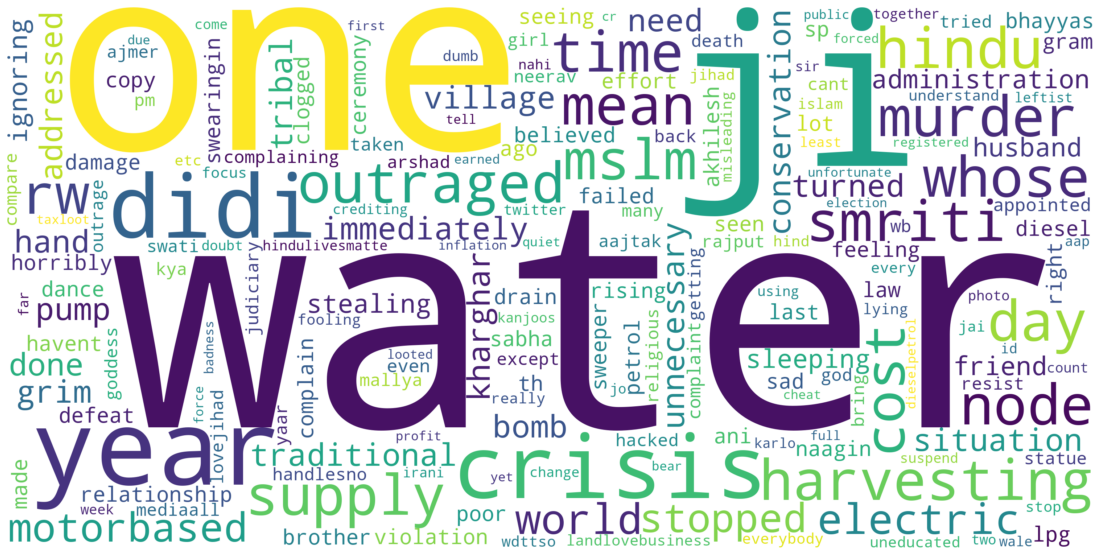

In [ ]:
wordcloud_creator(final_wc_strings)